<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
E-learning course on <br / ><br / >
Advanced Neutron Imaging
</p> 

# Filtering techniques
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

The purpose of a filter is to modify images with the aim to enhance the relevant information. Until now, we have only worked and modified single pixels. With filters we expand our horizons to invole the pixel neighborhood. 

Traditional filters are based on convolution, more advanced filters use partial differential equations for achive the filtering effect. In this tutorial, we will mainly look at different methods to improve the signal to noise ratio (SNR) and remove outliers which are very common in neutron images. 

Low SNR is a often returning problem in neutron images due to the low counting statistics for given 

### What you will learn in this tutorial
- Filter characteristics
- Different filter kernels
- Filtering in 2D vs 3D
- What is the cost of using a filter
- Some advanced filters

### Needed mathematical concepts
- Convolution
- Noise and signal to noise ratio
- Histograms

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import skimage.filters as flt
import skimage.morphology as morph
import sys

if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf QuantifyingNeutronImages
    !git clone https://github.com/ImagingELearning/resolution.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/ImageProcessing/tutorials/00_common/data/"
    sys.path.append("/content/scripts/python")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"

sys.path.append('../00_common/')

import readers as rd
    

## Real measurements are not perfect
You only get perfect images if draw them yourself. There is always noise present to some degree in a measurement. There are also different types of artifacts in neutron images like spots, lines and rings. 

In this tutorial, we will take a look at some filters that help making a confident analysis of the image data.

<img src="figures/imperfect_imaging_system.svg" style="width:800px"/>

## The data

In [187]:
img = rd.read_images('../00_common/data/beads/beads_{0:04d}.tif',first=0, last=100)
vimg = img[:,img.shape[1]//2]

  0%|          | 0/101 [00:00<?, ?it/s]

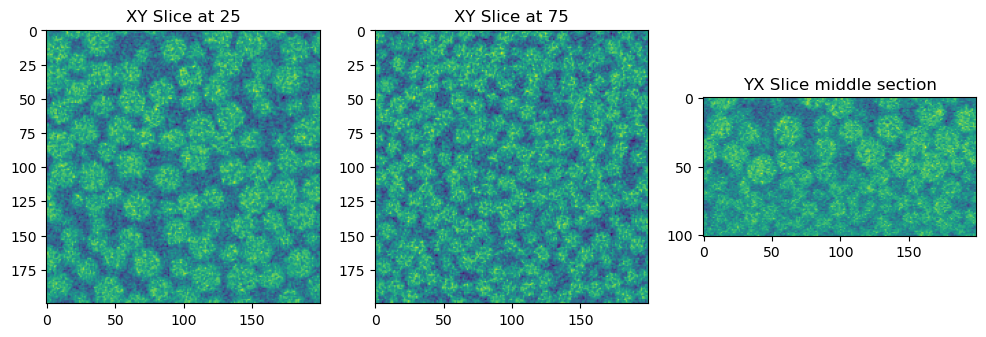

In [188]:
fig,ax = plt.subplots(1,3,figsize=(12,6))

ax[0].imshow(img[25])
ax[0].set_title('XY Slice at 25')
ax[1].imshow(img[75])
ax[1].set_title('XY Slice at 75')
ax[2].imshow(vimg)
ax[2].set_title('YX Slice middle section');

## Filter characteristics
Filters are characterized in terms of which information they suppress. Here, we talk about which frequencies pass through the filter and which blocked.

The two main filter types are:
- Low pass filters - keep the slow fluctuations in the image. Mostly, these are the main information in the image. Sharp edges and noise will be reduced, the image is blurred.  
- High pass filters - keep rapid changes in the image. A high pass filtered image show the edges but low gradients are suppressed. A backside of the edge enhancement is that also noise which fluctuate from pixel to pixel seems to be amplified.

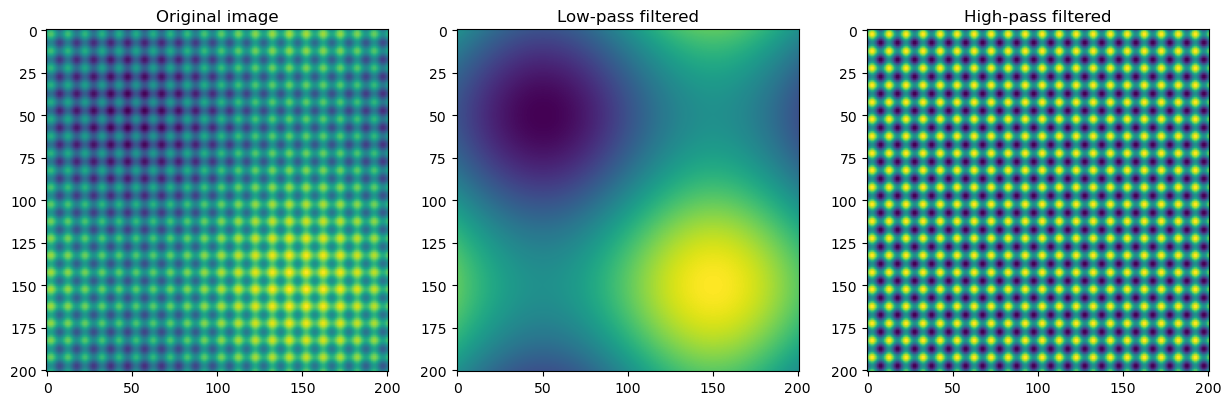

In [189]:
x,y = np.meshgrid(np.linspace(-np.pi,np.pi,201),np.linspace(-np.pi,np.pi,201))

lp = np.sin(x)+np.sin(y)
hp = np.sin(20*x)+np.sin(20*y)

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(lp+hp)
ax[0].set_title('Original image');
ax[1].imshow(lp);
ax[1].set_title('Low-pass filtered');
ax[2].imshow(hp);
ax[2].set_title('High-pass filtered');

## Convolution basics and filter kernels
https://scikit-image.org/docs/stable/api/skimage.filters.html

Before we start we need a visualization function to show the filter results

In [190]:
def show_result(A,B,name=None,k=1.96) :
    if name is None :
        name='Filtered'
        
    fig,ax = plt.subplots(2,2,figsize=(15,10))
    ax=ax.ravel()

    ax[0].imshow(A)
    ax[0].set_title("Original")
    ax[1].imshow(B)
    ax[1].set_title(name)
    d=A-B
    m=d.mean()
    s=d.std()
    ax[2].imshow(A-B,vmin=m-k*s,vmax=m+k*s)
    ax[2].set_title('Original - {0}'.format(name))
    ax[3].hist(A.ravel(),bins=100,alpha=0.5,label='Original')
    ax[3].hist(B.ravel(),bins=100,alpha=0.5,label=name);
    ax[3].legend()

### The Gauss filter

The Gauss filter has a filter kernel based on the 2D Gaussian distribution 

$$G_{\sigma}(x,y)=e^{-\frac{x^2+y^2}{2*\sigma^2}}$$

The filter is one of the first goto types when you want to reduce the image noise

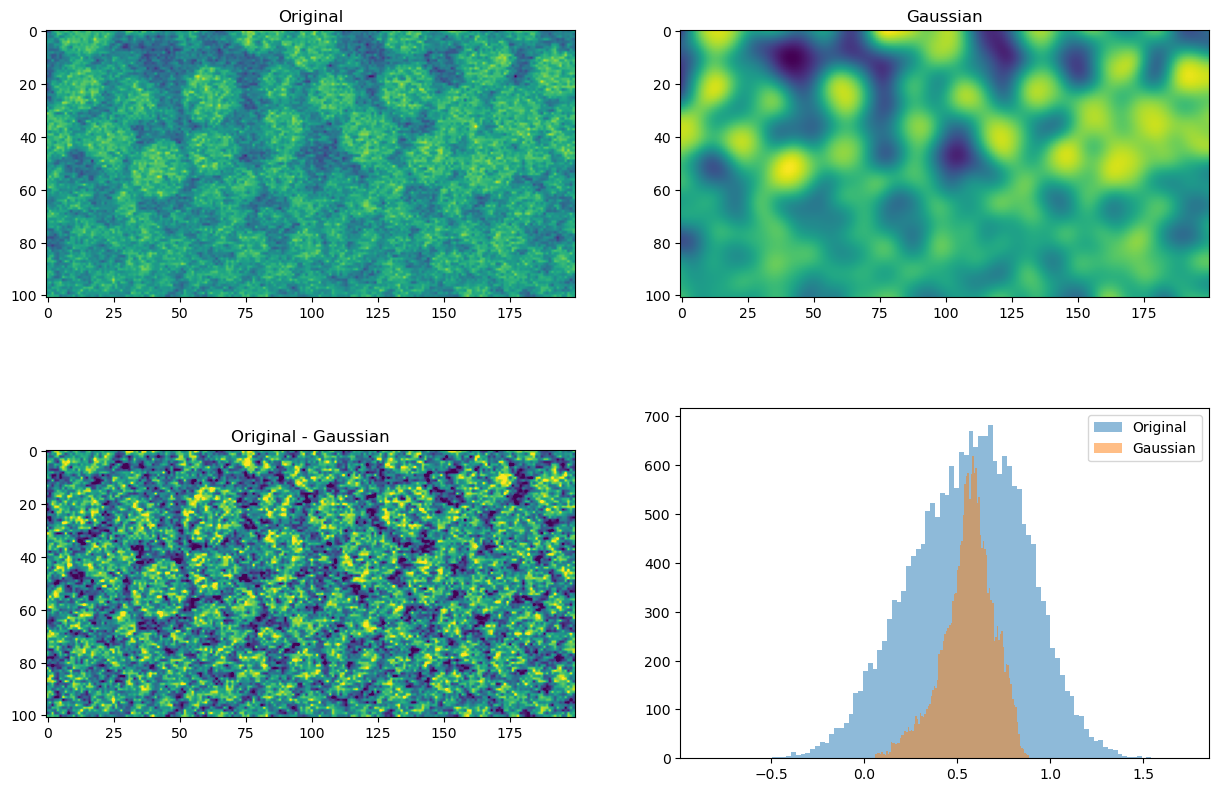

In [193]:
sigma = 4
g=flt.gaussian(vimg,sigma=sigma)
show_result(vimg,g,'Gaussian')

### The median filter

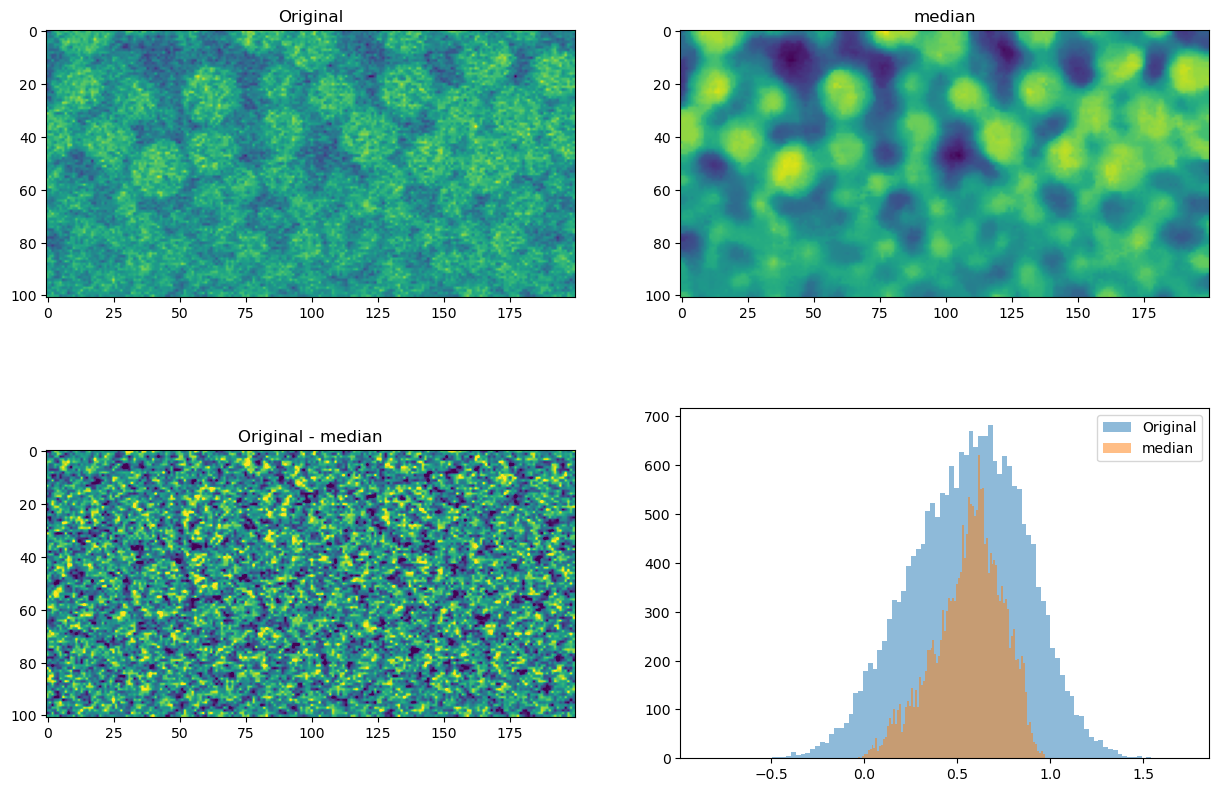

In [201]:
size=5
med=flt.median(vimg,footprint=morph.disk(size))
show_result(vimg,med, "median")

## Application - basic spot cleaning
One of the first artefacs you notice in neutron images are the spots. These are small outliers in the data with high intensity compared to the neighbor pixels. They are caused by gamma photon hitting the detector and thus leave a very intense response on the image. 

The figure below shows an example of some spot. They are as you can see not always perfect dots, but it could even be line traces.

<img src='figures/spotty_knot_closeup.png' style='width:400px'/>

The spots may look harmless in the radiograph. You can just rescale the display intervals. The do however have great impact on the reconstructed slices in tomography.

### Let's see what we can do

In [202]:
spots = rd.read_image('../00_common/data/spotimage.tif')

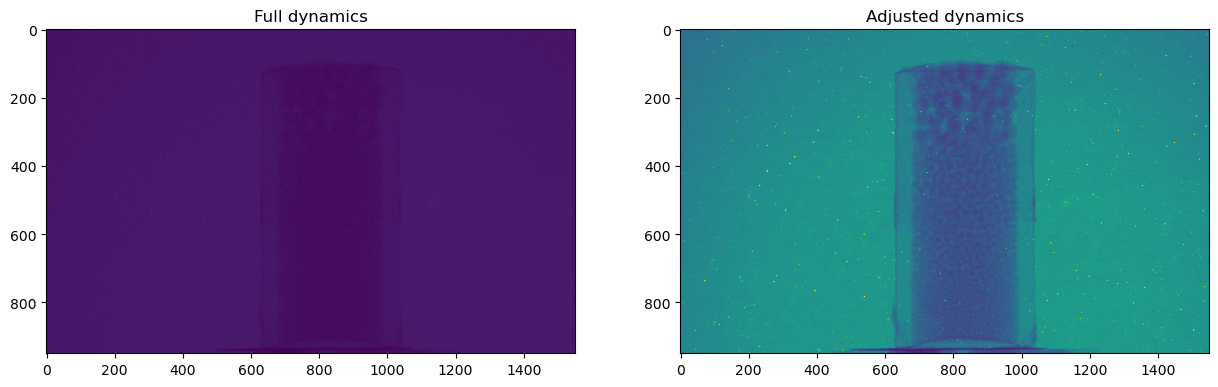

In [203]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].imshow(spots)
ax[0].set_title('Full dynamics')
ax[1].imshow(spots,vmin=300,vmax=3000)
ax[1].set_title('Adjusted dynamics');

#### Let's try a median filter
The median filter is good at suppressing outliers

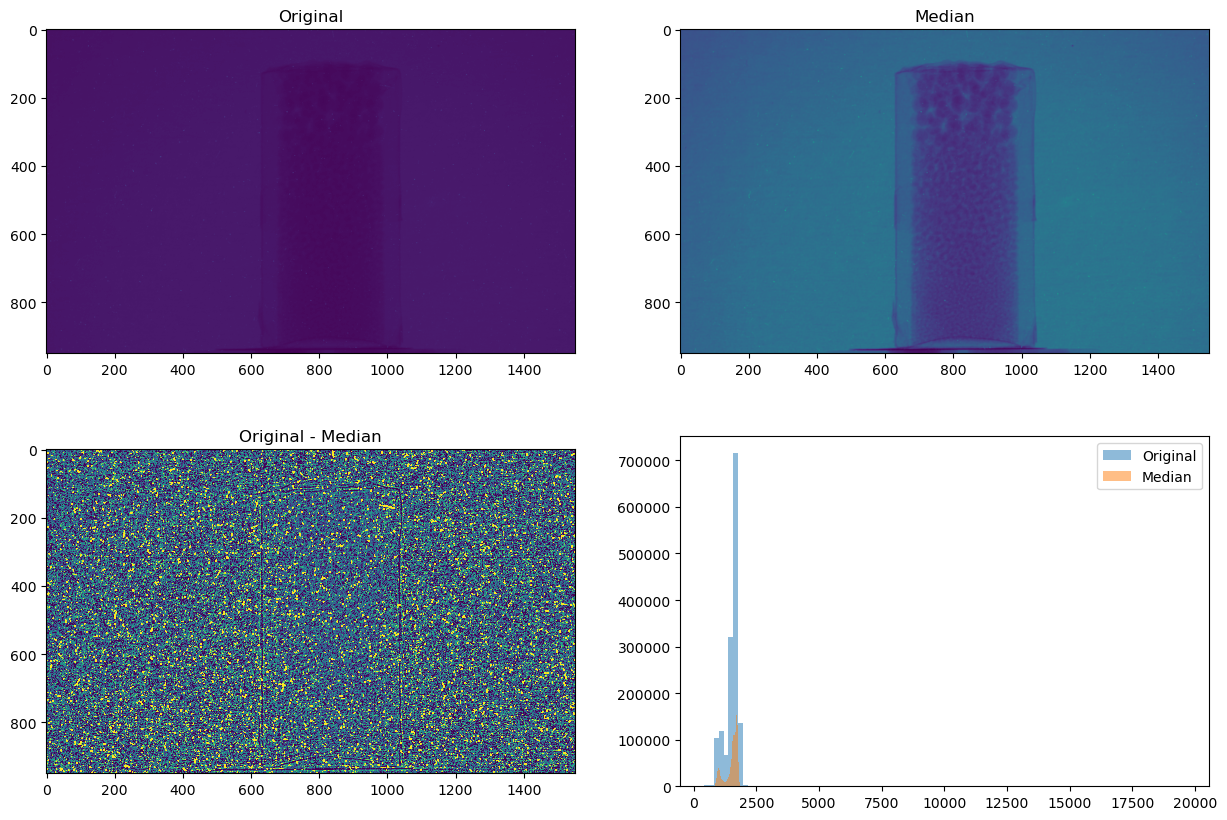

In [205]:
size=3
clean = flt.median(spots,footprint=np.ones((size,size))) 

show_result(spots,clean,'Median',k=0.1)

Looks good on first sight, but what if we tune the display interval a bit? 

Change the _k_ parameter to 0.1. What do you see?

### Methods to remove the spots
Spots are very localized rapid changes in the image data. This leads us in the direction of using a low-pass filter.
The options would be to use 
- Convolution filters with a Gauss or box kernel
- A median filter

These methods are however not ideal as they smooth the whole image regardless of outliers or not. 

A better choice is to work with a detect and replace concept that only targets the outlier spots. 

<img src='figures/spotclean_algorithm.svg' style='width:600px'/>

In [ ]:
def spot_clean(img,threshold,footprint) :
    mimg = flt.median(img,footprint=footprint)
    dimg = np.abs(img-mimg)
    
    mask = threshold<dimg 

    # option 1
    cleaned = mask * mimg + (1-mask) * img
    
    # option 2
#     cleaned       = img.copy()
#     cleaned[mask] = mimg[mask]
    
    return cleaned


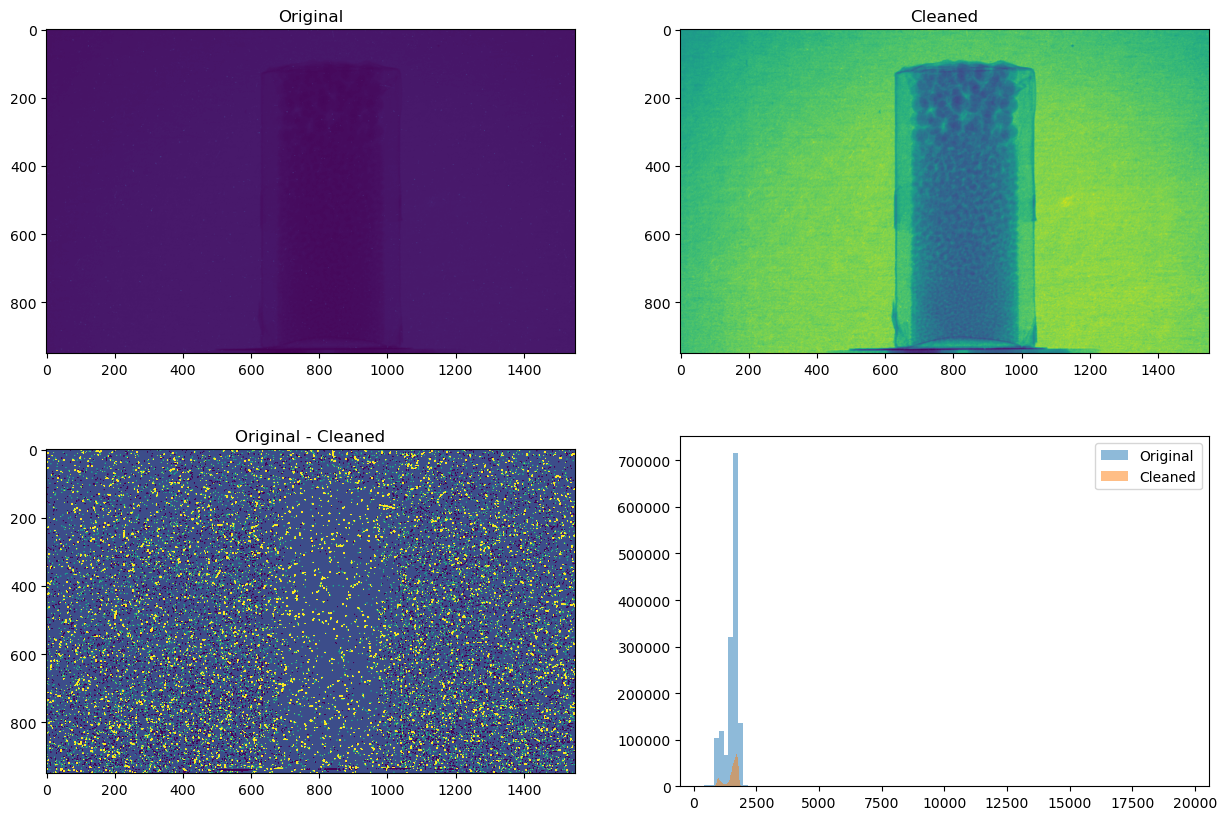

In [208]:
cleaned = spot_clean(spots,100,footprint=np.ones((5,5)))

show_result(spots,cleaned,'Cleaned',k=0.1)

How does it perform? Again try changing the _k_ to the same value you used for the median filter.

- Is it good? 
- Can you improve the performance? How?

## Filtering in 2D vs 3D

## The cost of filtering

In [ ]:
x,y = np.meshgrid(np.linspace(-1,1,201),np.linspace(-1,1,201))
x = np.concatenate((x,x),axis=1)
y = np.concatenate((y,y),axis=1)
R = np.sqrt(x**2+y**2)<0.995
plt.imshow(R,interpolation='none');

In [ ]:
fig,ax=plt.subplots(3,4,figsize=(15,8))

sigmas = [0.5,1,2,4]
for idx,sigma in enumerate(sigmas) :
    g=flt.gaussian(R,sigma=sigma)
    ax[0,idx].imshow(g,interpolation='none')
    ax[0,idx].vlines([201],ymin=0,ymax=g.shape[0]-1,color='lightblue',lw=2)
    ax[0,idx].hlines([100],xmin=0,xmax=g.shape[1]-1,color='red',lw=2)
    ax[1,idx].plot(np.arange(g.shape[1]),g[100])
    ax[2,idx].plot(g[:,201],np.arange(g.shape[0]))
    

Repeat the experiment with a median filter

## Some advanced filters
https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.denoise_tv_chambolle

In [ ]:
import skimage.restoration as restore

### Bilateral filtering

In [ ]:
blf=restore.denoise_bilateral(vimg,
                          win_size=None, 
                          sigma_color=None, 
                          sigma_spatial=1, # This is the important parameter for filter tuning
                          bins=1000, 
                          mode='constant', 
                          cval=0);

show_result(vimg,blf,"Bilateral")

### Non-local means filtering

In [ ]:
nl = restore.denoise_nl_means(vimg, 
                              patch_size=7, 
                              patch_distance=11, 
                              h=0.1,              # This is the important parameter for filter tuning
                              fast_mode=True, 
                              sigma=0.0, 
                              preserve_range=False, 
                              channel_axis=None)

show_result(vimg,nl,"Non-local means")

### Wavelet filter

In [ ]:
wav = restore.denoise_wavelet(vimg, 
                               sigma=None, 
                               wavelet='db1', 
                               mode='soft', 
                               wavelet_levels=None, 
                               convert2ycbcr=False, 
                               method='BayesShrink', 
                               rescale_sigma=True)

show_result(vimg,wav,'Wavelet denoising')

### Total variation filter

In [ ]:
cham= restore.denoise_tv_chambolle(vimg, 
                           weight=0.1, 
                           eps=0.0002, 
                           max_num_iter=200)

show_result(vimg,cham,'Chambolle')

## Summary